In [4]:
import os

import dill
import numpy as np
import jax.numpy as jnp
import pandas as pd
import geopandas as gpd

import jax 
from jax import random

import numpyro
from numpyro.infer import Predictive
import numpyro.distributions as dist

import arviz as az
import plotly.express as px 
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.pardir)

from aggGP import prev_model_gp_aggr, exp_sq_kernel, M_g, dist_euclid
from aggVAE import plot_process

jax.config.update("jax_default_device", jax.devices()[1])
print(f"Jax using device : {jax.devices()}")

Jax using device : [CudaDevice(id=0), CudaDevice(id=1)]


In [5]:
# Load variables
# --------------------------------- Load Data -------------------------------- #
data_dir = "../data/processed"

# Lat/Lon Values of artificial grid
x = np.load(os.path.join(data_dir,"lat_lon_x.npy")) #(2618,2)
# Low regional data
pol_pt_lo = np.load(os.path.join(data_dir,"low","pol_pt_lo.npy")) #(9,2618)
pt_which_pol_lo = np.load(os.path.join(data_dir,"low","pt_which_pol_lo.npy")) #(2618,)
# High regional data 
pol_pt_hi = np.load(os.path.join(data_dir,"high","pol_pt_hi.npy")) #(49, 2618,)
pt_which_pol_hi = np.load(os.path.join(data_dir,"high","pt_which_pol_hi.npy")) #(2618,)
# Dataframes
df_lo = gpd.read_file(os.path.join(data_dir, "low", "us_census_divisions","us_census_divisions.shp"))
df_hi = gpd.read_file(os.path.join(data_dir, "high", "us_state_divisions","us_state_divisions.shp"))


In [6]:
# -------------------------------- Load Model -------------------------------- #
with open("../model_weights/aggGP_samples1000_tt234min", 'rb') as file:
    mcmc = dill.load(file)

## Low Administritive Regions

In [7]:
# Arguments
args = {
    "n_specimens" : jnp.array(df_lo.tot_specs),  # total RDT tests per region
    "x" : jnp.array(x), # lat / lon values : (2618,2)
    "gp_kernel" : exp_sq_kernel, 
    "jitter" : 1e-4,
    "noise" : 1e-4,
    "M" : pol_pt_lo, #(9,2618)
    #todo : You can probably remove M2 as this is not needed
    #"M2" : pol_pt_hi,
    "combine" : False # Get combined results for 
}

2024-09-23 16:26:00.799377: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
pos_samples_lo = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic = False)

ss_lo = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True))
r_lo = np.mean(ss_lo["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r_lo)}")
print(f"Max r_hat for all aggGP low effects : {str(round(np.max(ss_lo['gp_aggr']['r_hat']),2))}")
print(f"kernel_length R-hat : {round(ss_lo['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss_lo['kernel_var']['r_hat'],2)}")



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -1.00      0.00     -1.00     -1.00     -1.00      0.50      1.00
           f[0]     -1.66      0.00     -1.66     -1.66     -1.66      0.50      1.00
           f[1]      0.52      0.00      0.52      0.52      0.52      0.50      1.00
           f[2]     -0.76      0.00     -0.76     -0.76     -0.76      0.50      1.00
           f[3]      0.13      0.00      0.13      0.13      0.13      0.50      1.00
           f[4]     -1.64      0.00     -1.64     -1.64     -1.64      0.50      1.00
           f[5]     -0.86      0.00     -0.86     -0.86     -0.86      0.50      1.00
           f[6]      1.41      0.00      1.41      1.41      1.41      0.50      1.00
           f[7]     -0.22      0.00     -0.22     -0.22     -0.22      0.50      1.00
           f[8]     -1.52      0.00     -1.52     -1.52     -1.52      0.50      1.00
           f[9]      1.93      0.00      1.93      1.

In [9]:
dir(mcmc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_args',
 '_cache',
 '_collection_params',
 '_compile',
 '_default_fields',
 '_get_cached_fns',
 '_get_cached_init_state',
 '_get_states_flat',
 '_init_state_cache',
 '_jit_model_args',
 '_kwargs',
 '_last_state',
 '_sample_field',
 '_set_collection_params',
 '_single_chain_mcmc',
 '_states',
 '_states_flat',
 '_warmup_state',
 'chain_method',
 'get_extra_fields',
 'get_samples',
 'last_state',
 'num_chains',
 'num_samples',
 'num_warmup',
 'post_warmup_state',
 'postprocess_fn',
 'print_summary',
 'progress_bar',
 'run',
 'sampler',
 'thinning',
 'transfer_states_to_host',
 'warmup']

In [10]:
mcmc.get_samples().keys()

dict_keys(['b0', 'f', 'gp_aggr', 'kernel_length', 'kernel_var', 'theta'])

In [11]:
mcmc.get_samples()["kernel_var"].shape

(1000,)

/hpc/home/idg/tools/miniforge3/envs/lo2hi/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/hpc/home/idg/tools/miniforge3/envs/lo2hi/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

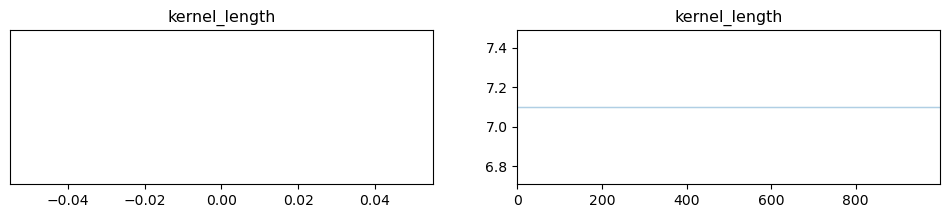

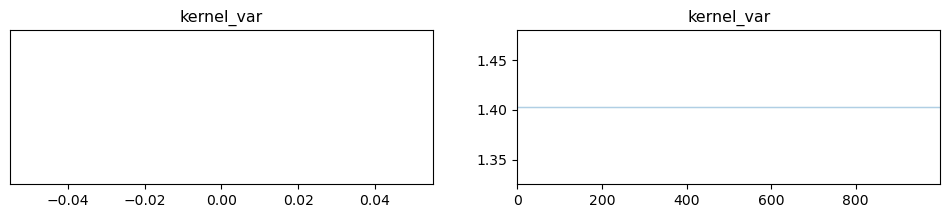

In [12]:
case_samples_az_gp_lo = az.from_numpyro(mcmc)
az.plot_trace(case_samples_az_gp_lo, var_names = ("kernel_length"))
az.plot_trace(case_samples_az_gp_lo, var_names = ("kernel_var"))

In [13]:
pos_samples_lo["theta"].shape
theta_mean_gp = pos_samples_lo["theta"].mean(axis =0)
bci_gp_25 = np.quantile(pos_samples_lo["theta"],0.25,axis = 0)
bci_gp_75 = np.quantile(pos_samples_lo["theta"],0.75, axis = 0)

df_lo["theta_gp"] = theta_mean_gp
#df["estimate"] <- NOT available
# Calculate Prevelance 
df_lo["obs_prev"] = df_lo.apply(lambda row: row.tot_cases / row.tot_specs, axis = 1)

#todo Ask Swapnil whats the difference between y, n_obs, estimate
#todo y seemed like the prevelance values (in my case number of cases)
#todo n_obs seemed to be number of test cases but the values too close to y (in my case number of test_specimens)
#todo what is estimate in this case ? (I dont have a estimate/theta-observed )

theta_obs = df_lo["obs_prev"]
theta_gp_est = df_lo["theta_gp"]
_max = np.max([theta_obs, theta_gp_est])
_min = np.min([theta_obs, theta_gp_est])

In [14]:
df_lo

,area,tot_specs,tot_cases,geometry,theta_gp,obs_prev
0,East North Central,62901,3762,"MULTIPOLYGON (((-91.50504 40.19993, -91.50666 ...",0.308557,0.059808
1,East South Central,1532,484,"MULTIPOLYGON (((-88.45324 30.20648, -88.44905 ...",0.291205,0.315927
2,Middle Atlantic,80827,2266,"MULTIPOLYGON (((-75.55064 39.63791, -75.5472 3...",0.005584,0.028035
3,Mountain,42251,5961,"POLYGON ((-103.00196 36.90957, -103.0022 36.71...",0.167534,0.141085
4,New England,20954,2964,"MULTIPOLYGON (((-71.58023 41.20484, -71.5773 4...",0.997618,0.141453
5,Pacific,48541,7167,"MULTIPOLYGON (((-122.41847 37.86176, -122.4184...",0.997271,0.147648
6,South Atlantic,12874,5185,"MULTIPOLYGON (((-81.87468 24.56361, -81.88775 ...",0.006327,0.402750
7,West North Central,9762,2948,"POLYGON ((-91.42663 40.37199, -91.42944 40.370...",1.000000,0.301987
8,West South Central,14849,873,"MULTIPOLYGON (((-90.66162 29.07226, -90.65212 ...",0.045483,0.058792


Text(0.5, 1.0, 'Low Res : GP Est Prevelance')

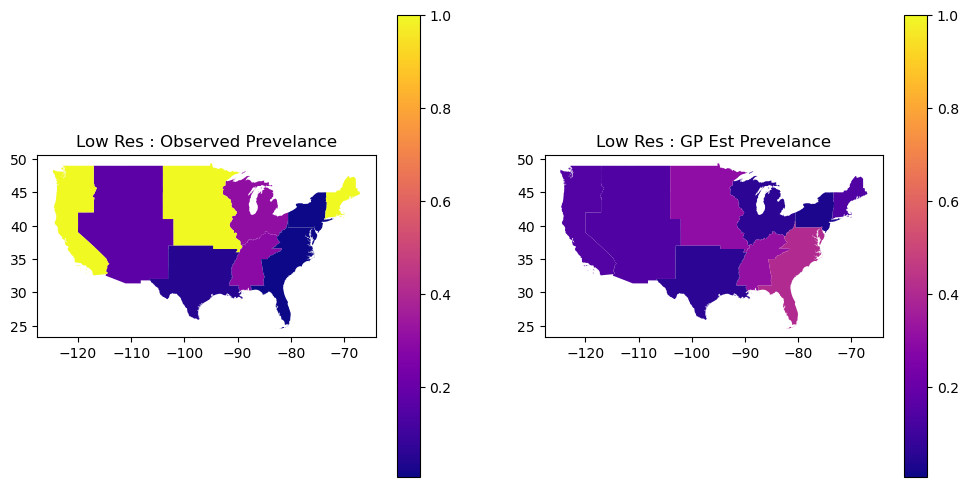

In [15]:
fig,ax = plt.subplots(1,2, figsize = (12,6))
df_lo.plot(column = "theta_gp", ax = ax[0], legend = True, cmap = "plasma", vmin = _min, vmax = _max)
df_lo.plot(column = "obs_prev", ax = ax[1], legend = True, cmap = "plasma", vmax = _max, vmin = _min)

ax[0].set_title("Low Res : Observed Prevelance")
ax[1].set_title("Low Res : GP Est Prevelance")

# Not Sure How to Predict without Getting Samples
- So run aggGP on Hi Resolution dataset

In [16]:
#todo : How do we compute posterior for the High Resolution Regions

In [17]:
#todo : We probably need a function like this to make predictions
# First finish VAE and as Swapnil what to do ?

# This code is from GP VAE 
def predict(rng_key, X, Y, X_test, var, length, noise, use_cholesky=True):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)

    # since K_xx is symmetric positive-definite, we can use the more efficient and
    # stable Cholesky decomposition instead of matrix inversion
    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), 0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )

    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [18]:
# Posterior predictions
gen_pos_samples_lo = Predictive(case_est_model_gp_aggr, pos_samples)(random.PRNGKey(1), args)
case_pos["cases"]

NameError: name 'case_est_model_gp_aggr' is not defined

In [35]:
p1 = px.line() 
for i in range(case_pos["cases"].shape[0]):
    p1.add_scatter(x = np.arange(case_pos["cases"].shape[1]), y = case_pos["cases"][i, :])
    
p1.update_layout(template = "plotly_white", showlegend = False)
p1.show()

In [36]:
case_pos["cases"]

Array([[   36,  9686,  3090, ...,  6106,     7, 49810],
       [   40,  9694,  3090, ...,  6099,     8, 49919],
       [   42,  9690,  3090, ...,  6169,     3, 49917],
       ...,
       [   36,  9685,  3090, ...,  6122,     1, 49916],
       [   39,  9677,  3090, ...,  6095,     3, 49727],
       [   35,  9691,  3090, ...,  6132,     6, 49839]], dtype=int32)

In [27]:
case_pos

{'cases': Array([[   36,  9686,  3090, ...,  6106,     7, 49810],
        [   40,  9694,  3090, ...,  6099,     8, 49919],
        [   42,  9690,  3090, ...,  6169,     3, 49917],
        ...,
        [   36,  9685,  3090, ...,  6122,     1, 49916],
        [   39,  9677,  3090, ...,  6095,     3, 49727],
        [   35,  9691,  3090, ...,  6132,     6, 49839]], dtype=int32),
 'gp_aggr_lo': Array([[-3.4048445,  7.0630226, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775803],
        [-3.4048445,  7.0630226, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775803],
        [-3.4048445,  7.0630226, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775803],
        ...,
        [-3.4048445,  7.0630245, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775817],
        [-3.4048445,  7.0630245, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775808],
        [-3.4048445,  7.0630245, 16.190361 , ...,  2.052967 , -4.2201385,
          3.4775808]], dtype=float32),
 